In [324]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import scipy as scp
from iminuit import Minuit, cost
from IPython.core.display import Latex
import random
import pandas as pd
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from IPython.core.display import Latex

### 3 monte carlo

#### 3.1

f(x) = C $x^{-0.9}$

##### 3.1.1

Analytically C should be x^0.9

##### 3.1.2

In [325]:
def f(x):
    return x**-0.9

/var/folders/bp/h0lnb5j91bn1mykh3m6j0dx00000gn/T/ipykernel_16938/4051346078.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


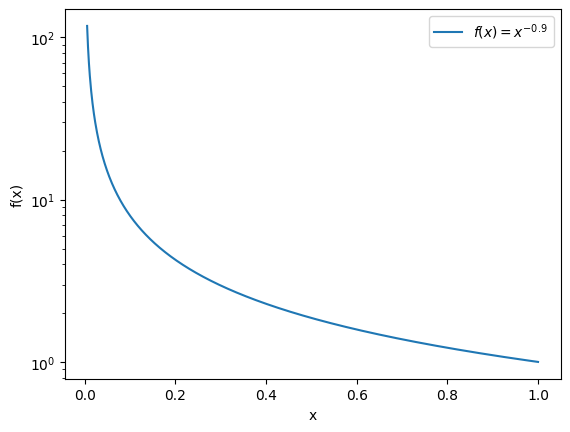

In [326]:
x = np.linspace(0.005, 1, 1000)

fig, ax = plt.subplots()
ax.plot(x, f(x), label=r'$f(x) = x^{-0.9}$')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_yscale('log')
ax.legend()
fig.show()



Here there is a well-defined interval I could give my simulation to do accept/reject. 

I can either use transformation of accept/reject initially. I would choose accept/reject. When defined from [0,1] I would be forced to use transformation, since y is not well-defined when x = [0,1], and thus does not fit inside a box.  

##### 3.1.3 - producing 10000 points according to f(x)

In [327]:
#accept/reject
N = 10000

y = np.random.uniform(0, 120, N)

x = np.random.uniform(0.005, 1, N)
y_check = f(x)

x_accept = []
y_accept = []

N_try = 0

for i in range(N):

    if y[i] < y_check[i]:
        N_try += 1
        x_accept.append(x[i])
        y_accept.append(y[i])

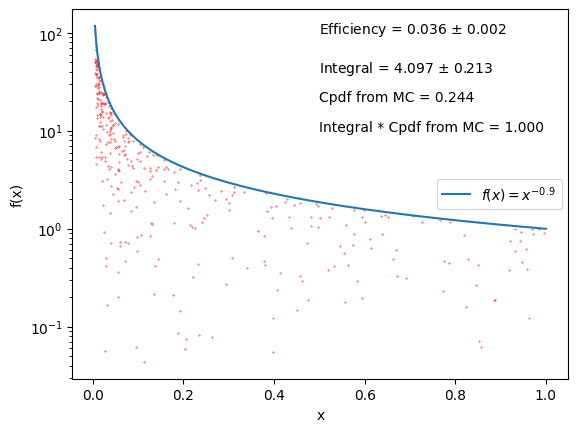

In [328]:
eff = N_try / N                         

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N) 

# Integral
integral =  eff * (np.max(x)-np.min(x)) * (np.max(y_check) - np.min(y_check))

# Error on integral
eintegral = eff_error * (np.max(x)-np.min(x)) * (np.max(y_check) - np.min(y_check))  

Cpdf_from_mc = 1/integral

should_be_one = integral* Cpdf_from_mc

ax.scatter(x_accept, y_accept, color='red', s=0.1)
ax.text(0.5, 100, f'Efficiency = {eff:.3f} $\pm$ {eff_error:.3f}')
ax.text(0.5, 40, f'Integral = {integral:.3f} $\pm$ {eintegral:.3f}')
ax.text(0.5, 20, f'Cpdf from MC = {Cpdf_from_mc:.3f}')
ax.text(0.5, 10, f'Integral * Cpdf from MC = {should_be_one:.3f}')
ax.set_yscale('log')
fig

##### 3.1.4

t is a sum of 50 random numbers from f(x). Create t 1000 times, and plot the results. Are they gaussian? Does the mean of all 1000 ts match the analytical expression?

In [329]:
def f_norm(x, C):
    return C * x**-0.9

def f_inverse(x, C):
    return (x/10*C)**10

N_exp = 1000
N_t = 50

ts = []

for i in range(N_exp):

    y = f_inverse(np.random.uniform(0.005, 1, N_t), Cpdf_from_mc)

    t = np.sum(y)

    ts.append(t)


/var/folders/bp/h0lnb5j91bn1mykh3m6j0dx00000gn/T/ipykernel_16938/1646928804.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


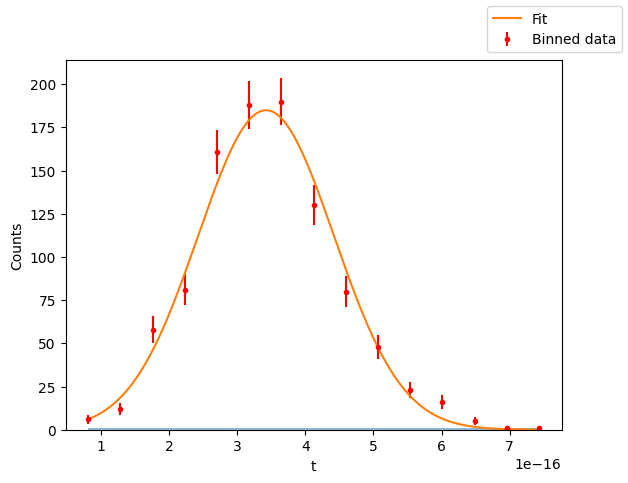

In [ ]:
N_bins = 15

# Fit the data

def histogram(data, bin_count):

    counts, bin_edges = np.histogram(data, bins=bin_count)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2


    x = bin_centers[counts>0]
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])

    return x, y, sy

ts, counts, errors = histogram(ts, N_bins)

fig1, ax1 = plt.subplots()
ax1.hist(ts, bins=N_bins, alpha=0.5, density=False)
ax1.errorbar(ts, counts, yerr=errors, label = 'Binned data', color = 'red', ls='', marker='.')
ax1.set_xlabel('t')
ax1.set_ylabel('Counts')

def gauss(x, mu, sigma, Ngauss, binwidth) :
    """Gaussian function, from "unnormalizing" the PDF"""
    return Ngauss * binwidth * 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

binwidth = (np.max(ts) - np.min(ts))/N_bins

gauss_fit = cost.LeastSquares(ts, counts, errors, gauss)

m = Minuit(gauss_fit, mu=1e-15, sigma=0.18e-15, Ngauss=15, binwidth=binwidth)

m.migrad()

params = m.values[:]

#plotting the fit and data




x = np.linspace(np.min(ts), np.max(ts), 1000)
y = gauss(x, *params)
ax1.plot(x, y, label='Fit')
fig1.legend()
fig1.show()


It is not exactly gaussian, more poisson formed.